In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [4]:
import pathlib
data_dir = pathlib.Path("Datasets/mcu_data_V2")

In [24]:
batch_size = 32
img_height = 224
img_width = 224
num_classes=3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3360 files belonging to 3 classes.
Using 2688 files for training.
Found 3360 files belonging to 3 classes.
Using 672 files for validation.


In [25]:
class_names = np.array(train_ds.class_names)
print(class_names)


['Arduino_Mega' 'Arduino_Uno' 'NodeMCU']


In [26]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5"

In [27]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=True)


In [28]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [29]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])


In [30]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1024)              1529968   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 1,533,043
Trainable params: 1,520,931
Non-trainable params: 12,112
_________________________________________________________________


In [31]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)


135/135 [==============================] - 3s 17ms/step - loss: 108316.1550 - acc: 0.3154


In [32]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=28,
                    callbacks=[batch_stats_callback])


Epoch 1/28
84/84 [==============================] - 21s 172ms/step - loss: 0.4366 - acc: 0.9680
Epoch 2/28
84/84 [==============================] - 15s 172ms/step - loss: 0.3382 - acc: 0.9985
Epoch 3/28
84/84 [==============================] - 15s 174ms/step - loss: 0.3292 - acc: 0.9989
Epoch 4/28
84/84 [==============================] - 15s 174ms/step - loss: 0.3550 - acc: 0.9904
Epoch 5/28
84/84 [==============================] - 15s 174ms/step - loss: 0.3207 - acc: 0.9985
Epoch 6/28
84/84 [==============================] - 15s 174ms/step - loss: 0.3155 - acc: 0.9974
Epoch 7/28
84/84 [==============================] - 15s 173ms/step - loss: 0.3031 - acc: 1.0000
Epoch 8/28
84/84 [==============================] - 15s 173ms/step - loss: 0.2963 - acc: 1.0000
Epoch 9/28
84/84 [==============================] - 15s 174ms/step - loss: 0.2895 - acc: 1.0000
Epoch 10/28
84/84 [==============================] - 15s 175ms/step - loss: 0.2827 - acc: 1.0000
Epoch 11/28
84/84 [====================

In [ ]:
history = model.fit(train_ds,
                    epochs=26,
                    validation_data=val_ds)

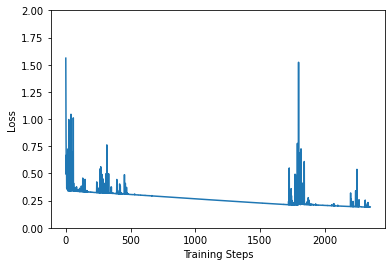

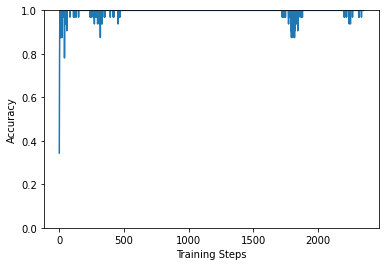

In [33]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)



In [34]:
from tensorflow import keras
import numpy as np

img = keras.preprocessing.image.load_img(
    'j1.jpg', target_size=(224, 224)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[-4.2431135 10.828187  -6.9147377]]
tf.Tensor([2.8485067e-07 9.9999976e-01 1.9694548e-08], shape=(3,), dtype=float32)
This image most likely belongs to Arduino_Uno with a 100.00 percent confidence.


In [35]:
t= time.time()

export_path = "saved_models/MobileNetV3_28_E_Trainable".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/MobileNetV3_28_E_Trainable/assets


INFO:tensorflow:Assets written to: saved_models/MobileNetV3_28_E_Trainable/assets


'saved_models/MobileNetV3_28_E_Trainable'